## Recurrent neural networks

The place to start seems to be [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). I'm also following the excellent Keras book p197 on RNNs.

## Setup code

In [71]:
import numpy as np
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.functional as F
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [72]:
def train_test_split(X, y, test_size:float):
    n = len(X)
    shuffle_idx = np.random.permutation(range(n))
    X = X[shuffle_idx]
    y = y[shuffle_idx]
    n_valid = int(n*test_size)
    n_train = n - n_valid
    X_train, X_valid = X[0:n_train].to(device), X[n_train:].to(device)
    y_train, y_valid = y[0:n_train].to(device), y[n_train:].to(device)
    return X_train, X_valid, y_train, y_valid

In [73]:
import matplotlib.pyplot as plt
def plot_history(history, yrange=(0.0, 5.00), figsize=(3.5,3)):
    plt.figure(figsize=figsize)
    plt.ylabel("Sentiment log loss")
    plt.xlabel("Epochs")
    loss = history[:,0]
    valid_loss = history[:,1]
    plt.plot(loss, label='train_loss')
    plt.plot(valid_loss, label='val_loss')
    # plt.xlim(0, 200)
    plt.ylim(*yrange)
    plt.legend(loc='lower right')
    plt.show()

In [74]:
def normal_transform(x, mean=0.0, std=0.01):
    "Convert x to have mean and std"
    return x*std + mean

def randn(n1, n2,
          device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
          dtype=torch.float,
          mean=0.0, std=0.01, requires_grad=False):
    x = torch.randn(n1, n2, device=device, dtype=dtype)
    x = normal_transform(x, mean=mean, std=std)
    x.requires_grad=requires_grad
    return x

In [75]:
def rtrain(model:nn.Module, train_data:TensorDataset, valid_data:TensorDataset,
           epochs=350,
           test_size=0.20,
           learning_rate = 0.002,
           batch_size=32,
           weight_decay=1.e-4,
           loss_fn=nn.MSELoss(),
           metric=nn.MSELoss(),
           print_every=30):
    "Train a regressor"
    history = []
    train_loader = DataLoader(train_data, batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
#     optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    for ei in range(epochs): # epochs
        for bi, (batch_x, batch_y) in enumerate(train_loader): # mini-batch
#             if len(batch_x)!=batch_size:
#                 print(f"\tBatch {bi:3d} len {len(batch_x)}")
            y_prob = model(batch_x)
            loss = loss_fn(y_prob, batch_y)

            optimizer.zero_grad()
            loss.backward() # autograd computes U.grad and M.grad
            optimizer.step()

        with torch.no_grad():
            loss        = loss_fn(model(train_data.tensors[0]), train_data.tensors[1])
            loss_valid  = loss_fn(model(valid_data.tensors[0]), valid_data.tensors[1])
            y_pred = model(train_data.tensors[0])
            metric_train = metric(torch.round(y_pred).cpu(), train_data.tensors[1].cpu())
            y_pred = model(valid_data.tensors[0])
            metric_valid = metric(torch.round(y_pred).cpu(), valid_data.tensors[1].cpu())

        history.append( (loss, loss_valid) )
        if ei % print_every == 0:
            print(f"Epoch {ei:3d} loss {loss:7.3f}, {loss_valid:7.3f}   {metric.__class__.__name__} {metric_train:4.3f}, {metric_valid:4.3f}")

    history = torch.tensor(history)
    return model, history

## Toy RNN that doesn't actually learn

Let's build an RNN for a known and obvious signal like a sine wave so we don't have to worry about text at first. Predict ith value of signal from previous k values.

### Create some fake data

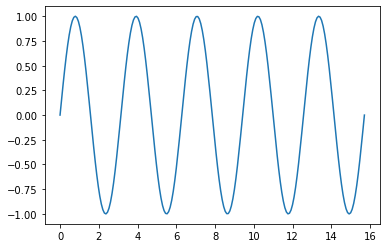

In [76]:
timesteps = 200
ncycles=5

x = np.linspace(0,ncycles*np.pi,timesteps)
siny = np.sin(2*x)
plt.plot(x,siny)

Now take slide window to get training data. ith value is predicted from previous k values

In [101]:
k = 5
X = []
y = []
for i in range(k,len(siny)):
    X.append(siny[i-k:i])
    y.append(siny[i])
X = torch.tensor(X).to(device)
y = torch.tensor(y).reshape(-1,1).to(device)
X.shape, y.shape

(torch.Size([195, 5]), torch.Size([195, 1]))

In [102]:
type(nn.MSELoss)

type

## Training a simple RNN model

I read [gist from karpathy](https://gist.github.com/karpathy/d4dee566867f8291f086) in addition to Karpathy's blog post. Using his notation, there are W_hh, W_xh, W_hy that transform the hidden state h to the next hidden state, transform's the input variable to next hidden state, and transform the hidden state to output. This [blog](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html#Creating-the-Network) was also useful but most useful was [fastai deep dive chapter](https://github.com/fastai/fastbook/blob/master/12_nlp_dive.ipynb).

Note, I think fastai book does:

```
h = h + self.i_h(x[:,t])
h = F.relu(self.h_h(h))
```

which is $W_{hh} (h^{(t-1)} + W_{xh} x^{(t)})$ but literature does $W_{hh} h^{(t-1)} + W_{xh} x^{(t)}$ so I'll stick with that.

In [103]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, 0.20)

### Record-by-record (slow)

It's much easier to understand the mechanism for RNNs if we look at one record at a time. This is definitely much slower but easier to understand than doing a single time step for all batch records at once. Easier to think about doing a single record it once because we just have a loop that computes a hidden state vector, one per record.

In [104]:
class RNN_slow(nn.Module):
    def __init__(self, input_features=4, output_features=1, hidden_size=10):
        super(RNN_slow, self).__init__()
        self.output_features = output_features
        self.hidden_size = hidden_size
        self.W_xh  = randn(hidden_size, 1, std=0.01).double()
        self.W_hh  = randn(hidden_size, hidden_size, std=0.01).double()
        self.W_hy  = randn(output_features, hidden_size, std=0.01).double()
        self.W_xh  = nn.Parameter(self.W_xh)
        self.W_hh  = nn.Parameter(self.W_hh)
        self.W_hy  = nn.Parameter(self.W_hy)

    def forward(self, x):
#         print("x", x.shape)
        batch_size = x.shape[0]
        nfeatures = x.shape[1]
        o = torch.zeros((batch_size, 1)).double()
        for i in range(batch_size):
            # Reset hidden state (history) at start of every record
            # Use same W_hh and W_xh matrices for all records until SGD update step
            h = torch.zeros((self.hidden_size, 1)).double()
            for j in range(nfeatures):  # for all input_features
                h = self.W_hh.mm(h) + self.W_xh * x[i, j]
                h = torch.relu(h)  # better than sigmoid for vanishing gradient
            # we now have an h vector that is the embedding for the ith record
            # we have encoded/embedded the x[i] record into h
            o[i] = self.W_hy.mm(h) # compute an output value, one per record
        return o.reshape(batch_size, self.output_features)

In [105]:
# test model
rnn = RNN_slow(input_features=k).to(device)
y_pred = rnn(torch.tensor(X,device=device)).detach().cpu()

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [106]:
print(f"{len(X_train)} training and {len(X_valid)} test records")

156 training and 39 test records


Epoch   0 loss   0.511,   0.423   L1Loss 0.657, 0.582
Epoch  20 loss   0.005,   0.007   L1Loss 0.196, 0.234
Epoch  40 loss   0.000,   0.000   L1Loss 0.191, 0.225
Epoch  60 loss   0.000,   0.000   L1Loss 0.191, 0.226
Epoch  80 loss   0.000,   0.000   L1Loss 0.191, 0.225


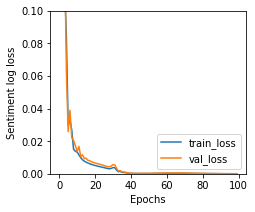

In [107]:
rnn = RNN(input_features=k, hidden_size=10).to(device)
model, history = rtrain(rnn, TensorDataset(X_train, y_train), TensorDataset(X_valid, y_valid),
                        loss_fn=torch.nn.MSELoss(),
                        metric=torch.nn.L1Loss(),
                        epochs=100,
                        learning_rate=.015,
                        weight_decay=0.00001,
                        batch_size=32,
                        print_every=20)

plot_history(history, yrange=(0,.1))

(-1.5, 1.5)

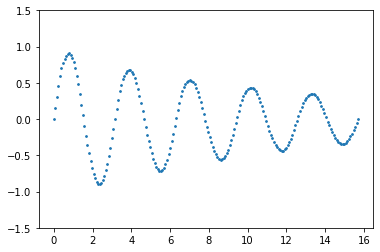

In [108]:
x = np.linspace(0,ncycles*np.pi,timesteps)
siny = np.sin(2*x)

n_output = timesteps
output = np.zeros(shape=(n_output,))
output[0:k] = siny[0:k] # seed with first k values from true data
for i in range(k,n_output):
    y_pred = rnn(torch.tensor(output[i-k:i]).reshape(1,k)).item()
#     print(i-k, ":", i-1, i, "->", y_pred)
    output[i] = y_pred

plt.scatter(x[0:n_output], output, s=3)
plt.ylim(-1.5,1.5)

**The effect of the nonlinearity**. In this particular case, as I suspected, the nonlinearity is not required. For example we could use a linear model probably to compute the coefficients to predict next steps locally.

If we take out the nonlinearity, then we are just computing

$$
h^{(t)} = W_{hh} h^{(t-1)} + W_{xh} x_t
$$

or:

$$
h = \sum_{j=1}^{p} W_{hh}^{n-p}W_{xh} x_j
$$

### Feature-by-feature (fast)

In [109]:
class RNN(nn.Module):
    def __init__(self, input_features=4, output_features=1, hidden_size=10):
        super(RNN, self).__init__()
        self.output_features = output_features
        self.hidden_size = hidden_size
        self.W_xh  = randn(hidden_size, 1, std=0.01).double()
        self.W_hh  = randn(hidden_size, hidden_size, std=0.01).double()
        self.W_hy  = randn(output_features, hidden_size, std=0.01).double()
        self.W_xh  = nn.Parameter(self.W_xh)
        self.W_hh  = nn.Parameter(self.W_hh)
        self.W_hy  = nn.Parameter(self.W_hy)
#         self.W_xh  = nn.Linear(1, hidden_size).double()
#         self.W_hh  = nn.Linear(hidden_size,    hidden_size).double()
#         self.W_hy  = nn.Linear(hidden_size,    output_features).double()
#         self.bh =   torch.zeros(hidden_size, 1, dtype=torch.float) 
#         self.by =   torch.zeros(hidden_size, 1, dtype=torch.float) 
        
    def forward(self, x):
#         print("x", x.shape)
        batch_size = x.shape[0]
        nfeatures = x.shape[1]
        h = torch.zeros((self.hidden_size,1)).double() # or h=0 placeholder: it's actually going to have shape len(x) by hidden_size
        for i in range(nfeatures): # for all input_features
#             print(h.shape)
            xi = x[:,i].reshape(1,-1)
            h = self.W_hh.mm(h) + self.W_xh.mm(xi)
            h = torch.relu(h) # better than sigmoid for vanishing gradient
        o = self.W_hy.mm(h)
        return o.reshape(batch_size, self.output_features)

In [110]:
# test model
rnn = RNN(input_features=k).to(device)
y_pred = rnn(torch.tensor(X,device=device)).detach().cpu()

/Users/parrt/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [111]:
print(f"{len(X_train)} training and {len(X_valid)} test records")

156 training and 39 test records


Epoch   0 loss   0.496,   0.409   L1Loss 0.657, 0.582
Epoch  20 loss   0.005,   0.007   L1Loss 0.194, 0.228
Epoch  40 loss   0.000,   0.001   L1Loss 0.192, 0.228
Epoch  60 loss   0.000,   0.001   L1Loss 0.192, 0.227
Epoch  80 loss   0.000,   0.000   L1Loss 0.191, 0.227


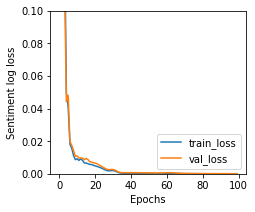

In [112]:
rnn = RNN(input_features=k, hidden_size=10).to(device)
model, history = rtrain(rnn, TensorDataset(X_train, y_train), TensorDataset(X_valid, y_valid),
                        loss_fn=torch.nn.MSELoss(),
                        metric=torch.nn.L1Loss(),
                        epochs=100,
                        learning_rate=.015,
                        weight_decay=0.00001,
                        batch_size=32,
                        print_every=20)

plot_history(history, yrange=(0,.1))

(-1.5, 1.5)

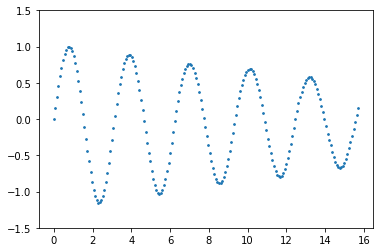

In [113]:
x = np.linspace(0,ncycles*np.pi,timesteps)
siny = np.sin(2*x)

n_output = timesteps
output = np.zeros(shape=(n_output,))
output[0:k] = siny[0:k] # seed with first k values from true data
for i in range(k,n_output):
    y_pred = rnn(torch.tensor(output[i-k:i]).reshape(1,k)).item()
#     print(i-k, ":", i-1, i, "->", y_pred)
    output[i] = y_pred

plt.scatter(x[0:n_output], output, s=3)
plt.ylim(-1.5,1.5)

**BIG LESSON**: make sure you are reinit'ing your model or creating new one. I was optimizing same model again and again, getting worse and worse results. Gotta create fresh RNN() each run.

batch_size=32 seems to be much better than 1, 2, 4, 8.  Converges too slowly.

Increasing epochs seems to get consistently decent results. 

hidden_size=50 from 10 doesn't seem to help.

hidden_size=4 is bad.